In [79]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from datetime import timedelta
from datetime import datetime
import scipy.stats as stats

import requests as r
import pandas as pd
import seaborn as s
import numpy as np

import holidays
ie_holidays = holidays.Ireland()

import postgres
import gmaps
import googlemaps
import json
import math

import xgboost as xgb
from sklearn import metrics

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import pickle

In [51]:
import importlib
importlib.reload(postgres.config)

<module 'config' from '/media/storage/College/S3/Github/DublinBus/Analytics/config.py'>

In [52]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [53]:
# data = pd.read_csv("stored_queries/combined145.csv")
# data.columns = ['dayofservice','tripid','lineid','direction','progrnumber','stopid','plannedDEP','plannedARR','actualDEP','actualARR','routeid']
# data.head(2)
# data.dtypes

In [54]:
# data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])
# data.lineid = data.lineid.astype('category')
# data.routeid= data.routeid.astype('category')
# data.sort_values(by=['dayofservice','lineid','tripid','direction','progrnumber'],inplace=True)

# Trips Data

In [55]:
tripsdata = pd.read_csv("stored_queries/trips_df.csv")
tripsdata.head()

,Unnamed: 0,dayofservice,tripid,lineid,routeid,direction,planned_arr,planned_dep,actual_arr,actual_dep
0,0,2018-06-17,7013606,7A,7A_85,1,66484,62400,67065.0,62901.0
1,1,2018-07-03,7137867,41C,41C_79,2,51620,47700,NaN,47293.0
2,2,2018-02-16,6258567,31,31_15,1,74041,71400,74297.0,71449.0
3,3,2018-08-27,7499178,67,67_6,2,59030,54720,NaN,54687.0
4,4,2018-08-27,7500294,44,44_36,2,85563,81000,85557.0,81004.0


In [56]:
tripsdata = tripsdata[['dayofservice', 'tripid', 'lineid', 'routeid', 'direction', 'actual_arr', 'actual_dep']]
tripsdata.dayofservice = pd.to_datetime(tripsdata.dayofservice)
tripsdata.dropna(inplace=True)

In [57]:
tripsdata['triplength'] = tripsdata.actual_arr - tripsdata.actual_dep
tripsdata.actual_arr = tripsdata.dayofservice + pd.to_timedelta(tripsdata.actual_arr, unit='seconds')
tripsdata.actual_dep = tripsdata.dayofservice + pd.to_timedelta(tripsdata.actual_dep, unit='seconds')
tripsdata['leavehour'] = tripsdata.actual_dep.dt.hour

In [58]:
tripsdata['weather_merge_time'] = tripsdata.actual_dep.dt.round('H') #  .dt is super useful. 

In [59]:
tripsdata.head()

,dayofservice,tripid,lineid,routeid,direction,actual_arr,actual_dep,triplength,leavehour,weather_merge_time
0,2018-06-17,7013606,7A,7A_85,1,2018-06-17 18:37:45,2018-06-17 17:28:21,4164.0,17,2018-06-17 17:00:00
2,2018-02-16,6258567,31,31_15,1,2018-02-16 20:38:17,2018-02-16 19:50:49,2848.0,19,2018-02-16 20:00:00
4,2018-08-27,7500294,44,44_36,2,2018-08-27 23:45:57,2018-08-27 22:30:04,4553.0,22,2018-08-27 23:00:00
5,2018-05-23,6782602,27,27_17,2,2018-05-23 19:37:32,2018-05-23 18:10:37,5215.0,18,2018-05-23 18:00:00
6,2018-02-16,6261199,53,53_20,1,2018-02-16 14:39:00,2018-02-16 14:01:04,2276.0,14,2018-02-16 14:00:00


# Weather Data

In [60]:
weather = pd.read_csv("stored_queries/weather.csv")

weather.icon = weather.icon.astype('category')
weather.dayofservice = pd.to_datetime(weather.dayofservice)

In [61]:
weather['rkey'] = weather.dayofservice + pd.to_timedelta(weather.hour, unit='hour')

# Combining Data

In [62]:
combinedtrip = tripsdata.merge(weather[['icon','temperature','humidity','windSpeed','rain','rkey','hour']], left_on='weather_merge_time', right_on='rkey', how='left')

## Adding features

Holidays

In [63]:
combinedtrip['holiday'] = combinedtrip.dayofservice.apply(lambda x: x in ie_holidays)

Weekday/Weekend

In [64]:
combinedtrip['weekend'] = combinedtrip.dayofservice.dt.weekday.isin([5,6])

Encoding Categorical Data

In [65]:
combinedtrip.icon = combinedtrip.icon.astype('category', categories=['partly-cloudy-day', 'partly-cloudy-night', 'clear-day', 'clear-night', 'rain', 'fog', 'cloudy', 'wind'])
# cmobinedtrip.
combinedtrip = pd.concat([combinedtrip, pd.get_dummies(combinedtrip.icon, prefix='icon')], axis=1)
combinedtrip.drop(columns=['icon'], inplace=True)

# Outliers / Errors / Null Values

In [66]:
combinedtrip.drop(columns=['routeid','weather_merge_time','rkey','tripid','actual_arr','actual_dep','dayofservice'], inplace=True)

In [67]:
combinedtrip.dropna(inplace=True)

In [68]:
combinedtrip.head()

,lineid,direction,triplength,leavehour,temperature,humidity,windSpeed,rain,hour,holiday,weekend,icon_clear-day,icon_clear-night,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_wind
0,7A,1,4164.0,17,63.52,0.72,20.07,0.0,17.0,False,True,0,0,0,0,1,0,0,0
1,31,1,2848.0,19,42.09,0.89,8.29,0.0,20.0,False,False,0,0,0,0,0,1,0,0
2,44,2,4553.0,22,55.60,0.80,6.79,0.0,23.0,False,False,0,0,0,0,0,1,0,0
3,27,2,5215.0,18,58.99,0.65,10.25,0.0,18.0,False,False,0,0,0,0,1,0,0,0
4,53,1,2276.0,14,47.28,0.69,13.11,0.1,14.0,False,False,0,0,0,0,1,0,0,0


In [70]:
combinedtrip.columns

Index(['lineid', 'direction', 'triplength', 'leavehour', 'temperature',
       'humidity', 'windSpeed', 'rain', 'hour', 'holiday', 'weekend',
       'icon_clear-day', 'icon_clear-night', 'icon_cloudy', 'icon_fog',
       'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain',
       'icon_wind'],
      dtype='object')

# Training Model

In [72]:
# need to put this in a loop over the pairs of stops. (unique)
target     = ['triplength']
predictors = ['temperature','humidity', 'windSpeed', 'rain', 'hour', 'holiday', 'weekend',
              'icon_clear-day', 'icon_clear-night', 'icon_cloudy', 'icon_fog',
              'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain','icon_wind']

# plt.figure()
# for pr in predictors:
#     try:
        
#         combinedtrip[pr].hist(bins=100, normed=True)
#         print(pr)
#         plt.figure()
        
#     except Exception:
#         continue
        
# plt.show()

In [73]:
modeldata = combinedtrip[combinedtrip.lineid=='145']
modeldata = modeldata[modeldata.direction==1]
modeldata.head()

,lineid,direction,triplength,leavehour,temperature,humidity,windSpeed,rain,hour,holiday,weekend,icon_clear-day,icon_clear-night,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_wind
210,145,1,4814.0,20,69.74,0.65,8.71,0.0,20.0,False,True,0,0,0,0,1,0,0,0
268,145,1,4809.0,15,67.19,0.73,7.02,0.0,15.0,False,True,0,0,0,0,1,0,0,0
329,145,1,6441.0,16,63.90,0.77,13.85,0.0,17.0,False,False,0,0,0,0,1,0,0,0
406,145,1,3496.0,22,57.08,0.73,16.64,0.0,22.0,False,True,0,0,0,0,0,1,0,0
427,145,1,3222.0,17,58.96,0.80,16.90,0.5,18.0,False,False,0,0,0,0,0,1,0,0


In [74]:
train, test = train_test_split(modeldata, test_size = 0.3, shuffle=True)

## Random Forest (skLearn)

In [80]:
# RFM

RFM = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
RFM.fit(train[predictors], train[target].values.ravel())
RFM_predictions = RFM.predict(test[predictors])

KeyboardInterrupt: 

In [ ]:
# # XGBOOST 
# gbm = xgboost.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.05)
# gbm.fit(train[predictors], train[target].values.ravel())
# predictions = gbm.predict(test_X)

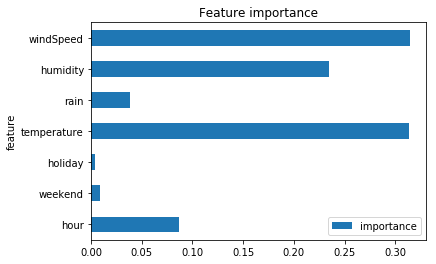

In [24]:
feature_importance = pd.DataFrame({'feature':predictors, 'importance': RFM.feature_importances_})

feature_importance.set_index('feature', inplace=True)
feature_importance.plot.barh(title='Feature importance')

(array([1.74788469e-06, 8.73942346e-07, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.73942346e-07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.74788469e-06,
        1.74788469e-06, 0.00000000e+00, 3.49576938e-06, 6.11759642e-06,
        2.62182704e-06, 3.49576938e-06, 1.04873082e-05, 1.13612505e-05,
        1.48570199e-05, 1.66049046e-05, 1.66049046e-05, 2.18485587e-05,
        2.44703857e-05, 3.14619245e-05, 2.88400974e-05, 1.74788469e-05,
        1.31091352e-05, 3.05879821e-05, 2.97140398e-05, 2.27225010e-05,
        4.80668290e-05, 6.64196183e-05, 1.00503370e-04, 1.35461064e-04,
        1.80032123e-04, 2.63056646e-04, 3.81038863e-04, 4.52702135e-04,
        5.17373869e-04, 5.54953390e-04, 6.03894161e-04, 5.53205505e-04,
        5.97776565e-04, 5.20869638e-04, 4.72802809e-04, 3.85408575e-04,
        2.47325684e-04, 1.93141259e-04, 1.31091352e-04, 1.057470

/home/ciaran/.conda/envs/BusEnv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ciaran/.conda/envs/BusEnv/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if sys.path[0] == '':


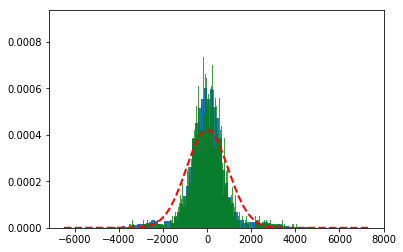

945.7828892490005 5.188208343380757


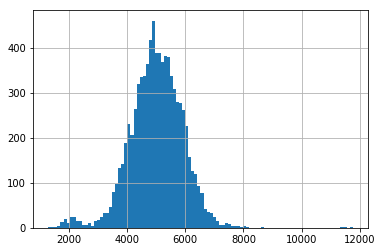

In [26]:
residuals = RFM_predictions - test.triplength
plt.hist(residuals, bins=100, density=True)


# best fit of data
(mu, sigma) = stats.norm.fit(RFM_predictions - test.triplength)

# # The histogram of the data
# n, bins, patches = plt.hist(RFM_predictions - test.triplength, 2000, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.show()

print(sigma, mu)

test.triplength.hist(bins=100)

## XGBoost

In [81]:
train.head()

,lineid,direction,triplength,leavehour,temperature,humidity,windSpeed,rain,hour,holiday,weekend,icon_clear-day,icon_clear-night,icon_cloudy,icon_fog,icon_partly-cloudy-day,icon_partly-cloudy-night,icon_rain,icon_wind
57301,145,1,4215.0,20,47.97,0.83,9.35,0.0,20.0,False,False,0,0,0,0,0,1,0,0
499738,145,1,4760.0,15,67.14,0.75,5.27,0.7,16.0,False,True,0,0,0,0,1,0,0,0
980291,145,1,5419.0,11,64.07,0.52,12.13,0.1,12.0,False,False,0,0,0,0,1,0,0,0
1707188,145,1,3945.0,23,54.38,0.74,5.77,0.0,23.0,False,False,0,1,0,0,0,0,0,0
925747,145,1,2265.0,9,44.51,0.89,7.46,0.0,9.0,False,False,0,0,0,0,1,0,0,0


In [82]:
X_train, X_test, y_train, y_test = train_test_split(combinedtrip[predictors],combinedtrip[target].values.ravel(), test_size=0.2)

In [84]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
#     'tree_method':'gpu_hist',
    'eta':0.1,
    'max_depth':10
}
num_rounds = 100
model = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'Test')], verbose_eval=5, early_stopping_rounds=10)


[0]	Test-rmse:3743.83
Will train until Test-rmse hasn't improved in 10 rounds.
[5]	Test-rmse:2459.49
[10]	Test-rmse:1808.56
[15]	Test-rmse:1517.16
[20]	Test-rmse:1401.03
[25]	Test-rmse:1357.89
[30]	Test-rmse:1341.96
[35]	Test-rmse:1336.05
[40]	Test-rmse:1333.53
[45]	Test-rmse:1332.45
[50]	Test-rmse:1331.93
[55]	Test-rmse:1331.63
[60]	Test-rmse:1331.36
[65]	Test-rmse:1331.14
[70]	Test-rmse:1330.95
[75]	Test-rmse:1330.77
[80]	Test-rmse:1330.61
[85]	Test-rmse:1330.48
[90]	Test-rmse:1330.34
[95]	Test-rmse:1330.26
[99]	Test-rmse:1330.16


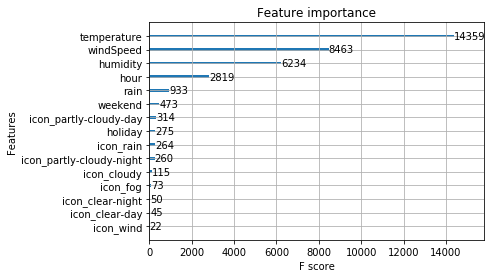

In [85]:
xgb.plot_importance(model)

(array([1.27907536e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.27907536e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.27907536e-08, 0.00000000e+00, 1.27907536e-08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.55815073e-08,
        0.00000000e+00, 2.55815073e-08, 0.00000000e+00, 1.27907536e-08,
        1.27907536e-08, 0.00000000e+00, 5.11630146e-08, 2.55815073e-08,
        3.83722609e-08, 0.00000000e+00, 2.55815073e-08, 5.11630146e-08,
        1.27907536e-07, 6.39537682e-08, 1.27907536e-07, 1.79070551e-07,
        1.66279797e-07, 2.81396580e-07, 3.83722609e-07, 3.70931856e-07,
        5.11630146e-07, 7.54654465e-07, 9.33725016e-07, 1.75233325e-06,
        2.75001203e-06, 4.02908740e-06, 6.74072717e-06, 1.22919143e-05,
        1.89686877e-05, 2.97640837e-05, 4.29897230e-05, 6.01549144e-05,
        7.97119767e-05, 9.86039199e-05, 1.22266814e-04, 1.415296

/home/ciaran/.conda/envs/BusEnv/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if sys.path[0] == '':


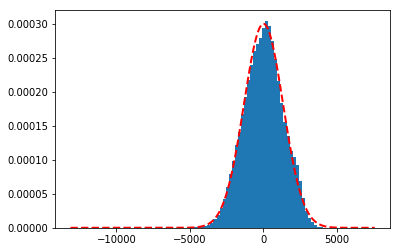

1330.1634069704198 1.941232992834963


In [92]:
xgbpreds = model.predict(dtest)

plt.hist(xgbpreds - y_test, bins=100, density=True)

# best fit of data
(xmu, xsigma) = stats.norm.fit(xgbpreds - y_test)

# # The histogram of the data
# xn, xbins, xpatches = plt.hist(xgbpreds - y_test, 2000, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
xy = mlab.normpdf(xbins, xmu, xsigma)
xl = plt.plot(xbins, xy, 'r--', linewidth=2)
plt.show()

print(xsigma,xmu)

# Saving Model

In [93]:
# import sys
# sys.getsizeof(model.best_iteration)

Random Forest (using pickle) - memory errors

In [94]:
# save model
# pickle.dump(RFM, open("modelFiles/Route145.sav", 'w'))

# load model
# loaded_model = pickle.load(open("modelFiles/route145.sav", 'rb'))

XGBoost model

In [95]:
model.save_model("modelFiles/route145.model")

In [96]:
# samplehow to load model.

model3 = xgb.Booster()
model3.load_model("modelFiles/route145.model")

In [97]:
model3.predict(dtest) - model.predict(dtest)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)